# Prices Simulation

First we download some stock historical prices.   
Each stock is identified by a Ticker which is an abbreviation of it's name.    
For this we use the ``pandas_datareader`` library which allows us to download the stock prices from Yahoo Finance Data.

In [2]:
from datetime import datetime
import pandas_datareader.data as web

stocks = ["ge", "intc", "amd", "gold", "spy", "ko", "pep"]
start, end = datetime(2017, 1, 1), datetime(2020, 1, 1)
df = web.DataReader(stocks, "stooq", start=start, end=end)
df_prices = df["Close"]

We define expected annual returns with the varibale name ``era`` and a number of simulated prices ``spn`` to be predicted for each previously downloaded stock.

We intentionally chose an unreal expected return like -0.8 for the *ge* Ticker and -0.99 for the *spy* Ticker to stress the simulation!

In [3]:
ear = {
    "ge": -0.8,
    "intc": 10,
    "amd": -0.1,
    "gold": -0.5,
    "spy": -0.99,
    "ko": 0.08,
    "pep": 0.01,
}
spn = 254

Now prepare the simulation.
1. check that the ``df_prices`` contains prices.
2. Instantiate the ``simulation`` object.

In [4]:
from portfolioqtopt.simulation.stocks import Stocks
from portfolioqtopt.simulation.simulation import Simulation

stocks_history = Stocks(df=df_prices)

simulation = Simulation(stocks_history, er=ear, m=spn)

We are now ready to run the simulation and obtain a ``tuple`` containing future returns, covariance and prices respectively names ``future_returns``, ``future_cov``, ``future_prices``.

In [5]:
future_returns, future_cov, future_prices = simulation(order=12)

2023-01-17 15:34:59.084 | WARNING  | portfolioqtopt.simulation.simulation:correlate:73 - Correlated daily returns not all inf to 1!
2023-01-17 15:35:00.377 | INFO     | portfolioqtopt.simulation.simulation:get_returns_adjustment:132 - dl=Polynomial([   1.51433817,  254.15656148, -127.21825357,   84.94688642,
        -63.84250402,   51.20515102,  -42.80150884,   36.8173785 ,
        -32.33852332,   28.86736046,  -25.43382485,   23.09090909], domain=[-1.,  1.], window=[-1.,  1.], symbol='x'), r_min=-0.05928982757578998, r_max=0.0616914500958858
2023-01-17 15:35:00.379 | INFO     | portfolioqtopt.simulation.simulation:get_returns_adjustment:132 - dl=Polynomial([  -2.46967966,  254.10798858, -127.14409777,   84.84679781,
        -63.71610769,   51.05204654,  -42.62128794,   36.60967655,
        -32.10661732,   28.62221319,  -25.43546584,   23.09090909], domain=[-1.,  1.], window=[-1.,  1.], symbol='x'), r_min=-0.04767925349296216, r_max=0.05435348107939767
2023-01-17 15:35:00.380 | INFO   

To visualize the results we can plot the historical prices follow by the simulated ones on the same plot.

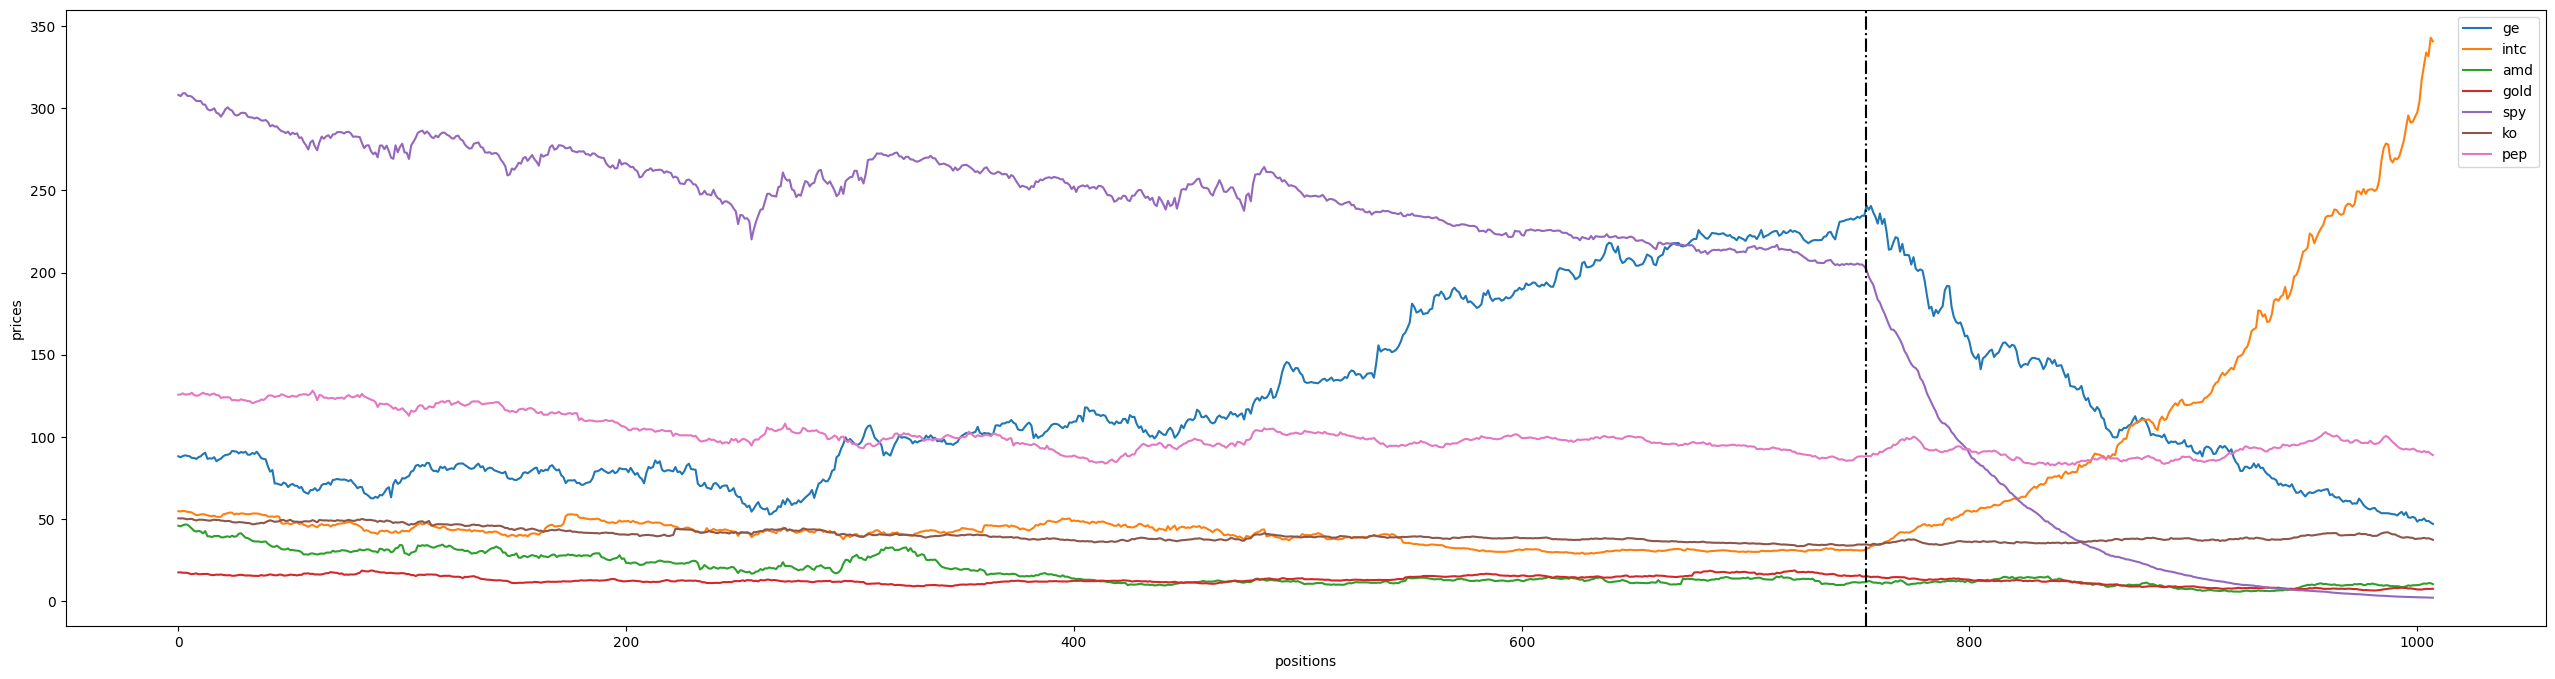

In [10]:
import numpy as np
import matplotlib.pyplot as plt

n = stocks_history.df.to_numpy().shape[0]
m = future_prices.shape[1]

# legend
stocks_names = stocks_history.df.columns
k = len(stocks_names)

prices = np.vstack(
    (stocks_history.prices.T, future_prices[:, 1:].T)
)  # shape (n + m, k)

fig, ax = plt.subplots(figsize=(32, 8))
ax.plot(prices, label=stocks_names)
ax.axvline(x=n, ymin=0, ymax=1, c="black", linestyle="-.")
ax.set_xlabel("positions")
ax.set_ylabel("prices")
ax.legend();

To be sure that all is as expected we verify that:

1. The covariance of the daily returns of our simulated prices are the same as the historical one.
   
We call ``sar`` the simulated anual returns and ``dar`` the desired anual returns and made an assertion to verify that they are very close to each other.

In [11]:
sar = future_prices.T[-1, :] / future_prices.T[0, :] - 1
dar = np.array(list(ear.values()))  # desired anual returns
assert np.allclose(sar, dar)

2. The anual returns of the each simulated stock are the same as the given ones.

For that we can write a simple function call ``get_daily_returns()`` to compute the daily returns given an array of prices.

In [12]:
import numpy.typing as npt


def get_daily_returns(array: npt.NDArray) -> npt.NDArray:
    # array: shape (n, k)
    # output: shape (n-1, k)
    return np.diff(array, axis=1) / array[:, :-1]

Finally we verify that the obtained covariance is idendical to the one compute with the simulated prices.

1. Compute the daily return.  
2. Compute the covariance ``future_cov`` and ``history_cov``.
3. Verify that they are very close to each other.

In [15]:
future_returns = get_daily_returns(future_prices)
history_returns = get_daily_returns(stocks_history.prices)
future_cov = np.cov(future_returns)
history_cov = np.cov(history_returns)

assert np.allclose(history_cov, future_cov)

All work as expected!

In [16]:
import pandas as pd

simulated_prices = pd.DataFrame(future_prices.T, columns=ear).to_json()  # A sting...